`antman` kernel

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import os 
import re
from pygenomeviz import GenomeViz
import scipy.stats as stats
import seaborn as sns
sys.path.append('../')
from transcriptomics import *
from hcr import * 
from plotting import * 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
white_plotting()

Initializing transcriptomics package
Initializing HCR package
Initializing plotting package


In [3]:
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

In [4]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [5]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    or_db.at[i, 'n_transcripts'] = len(gene.transcripts)
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    if len(transcript.cds) > 0:
        or_db.at[i,'cds_start'] = int(transcript.cds[0].position[0]) if transcript.strand == '+' and len(transcript.cds) > 0 else int(transcript.cds[0].position[1])
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
    or_db.at[i,'ta_index'] = or_db.loc[or_db.tandem_array == row['tandem_array']].index.get_loc(i) + 1
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db['ta_index'].astype(int)
or_db.head(5)

,chromosome,gene_name,tandem_array,rank,orientation,n_transcripts,start,end,cds_start,strand,chr,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',1.0,6504395,6510987,6510023.0,-,Chr1,False,2,1
1,1,Or5-Q1,70,2,5',1.0,6511625,6514800,6514732.0,-,Chr1,False,2,2
2,1,Or5-Orco,72,3,NaN,1.0,10910490,10919026,10911295.0,+,Chr1,False,2,1
3,1,Or5-Q2,72,4,NaN,2.0,10934666,10938750,10934709.0,+,Chr1,False,2,2
4,1,Or5-9E1,73,5,NaN,7.0,10980671,10984094,10981538.0,+,Chr1,True,1,1


In [6]:
# Load genome
genome_path = "../raw-data/OBir/genome/Obir.assembly.v5.4.fasta"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))

### Load csRNAseq

In [7]:
# Load csRNAseq data
csRNAseq_dir = "../raw-data/OBir/csRNAseq/"
csRNAseq_files = [f for f in os.listdir(csRNAseq_dir) if f.endswith('.bedGraph')]
print(f"Found {len(csRNAseq_files)} csRNAseq files.")
print(csRNAseq_files)

Found 4 csRNAseq files.
['Ooceraea_biroi-WholeAdults_csRNA-r1.negStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_sRNA-r1.posStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_sRNA-r1.negStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_csRNA-r1.posStrand.renamed.bedGraph']


In [8]:
# Specify adult csRNAseq data, pos and neg strands 
csWAneg_path = os.path.join(csRNAseq_dir, 'Ooceraea_biroi-WholeAdults_csRNA-r1.negStrand.renamed.bedGraph')
csWApos_path = os.path.join(csRNAseq_dir, 'Ooceraea_biroi-WholeAdults_csRNA-r1.posStrand.renamed.bedGraph')

In [9]:
csWAneg = pd.read_csv(csWAneg_path, sep="\t", header=None, names=["chrom", "start", "end", "value"])
csWAneg['strand'] = '-' 
csWApos = pd.read_csv(csWApos_path, sep="\t", header=None, names=["chrom", "start", "end", "value"])
csWApos['strand'] = '+'
csWA = pd.concat([csWAneg, csWApos], ignore_index=True)
csWA

,chrom,start,end,value,strand
0,"track type=bedGraph name=""Ooceraea_biroi-Whole...",NaN,NaN,NaN,-
1,Chr1,110792.0,110823.0,-1.24,-
2,Chr1,122682.0,122683.0,-1.24,-
3,Chr1,122683.0,122684.0,-4.96,-
4,Chr1,122684.0,122714.0,-6.21,-
...,...,...,...,...,...
920935,QOIP01000080.1,13168.0,13172.0,3.72,+
920936,QOIP01000080.1,13172.0,13173.0,4.96,+
920937,QOIP01000080.1,13173.0,13174.0,8.69,+
920938,QOIP01000093.1,6524.0,6549.0,1.24,+


In [10]:
# Drop rows with NaN in value column, reset index, also drop rows without "Chr" in the chrom 
csWA = csWA.dropna(subset=['value'])
csWA = csWA[csWA['chrom'].str.contains("Chr")]
csWA = csWA.reset_index(drop=True)  
csWA['start'] = csWA['start'].astype(int)
csWA['end'] = csWA['end'].astype(int)
csWA['value'] = np.abs(csWA['value'])  # Ensure values are positive
csWA['length'] = csWA['end'] - csWA['start']
csWA['location'] = csWA['chrom'] + ':' + csWA['start'].astype(str) + '-' + csWA['end'].astype(str)
csWA

,chrom,start,end,value,strand,length,location
0,Chr1,110792,110823,1.24,-,31,Chr1:110792-110823
1,Chr1,122682,122683,1.24,-,1,Chr1:122682-122683
2,Chr1,122683,122684,4.96,-,1,Chr1:122683-122684
3,Chr1,122684,122714,6.21,-,30,Chr1:122684-122714
4,Chr1,138377,138407,2.48,-,30,Chr1:138377-138407
...,...,...,...,...,...,...,...
920146,Chr14,8701726,8701732,6.21,+,6,Chr14:8701726-8701732
920147,Chr14,8701732,8701733,4.97,+,1,Chr14:8701732-8701733
920148,Chr14,8701733,8701756,3.73,+,23,Chr14:8701733-8701756
920149,Chr14,8702324,8702344,1.25,+,20,Chr14:8702324-8702344


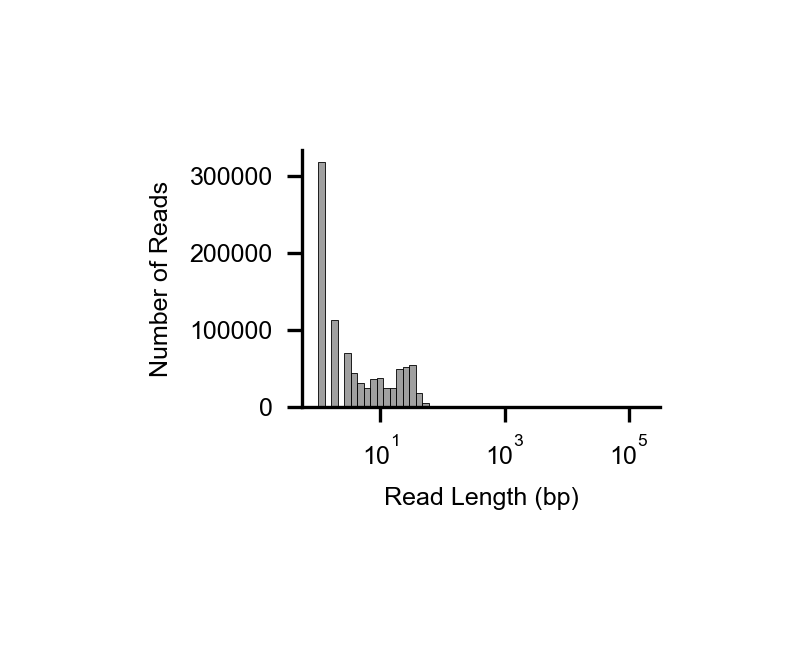

In [11]:
# Histogram of csWA read lengths 
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=300) 
sns.histplot(csWA['length'], bins=50, ax=ax, color='grey', kde=False, log_scale=True)
ax.set_xlabel('Read Length (bp)', fontsize=6)
ax.set_ylabel('Number of Reads', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-read-length-histogram.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

### Calculate proportion of tandemly-arrayed genes with bidirectional peaks in the intergenic region 

In [12]:
min_cds_length = 100 
max_cds_length = 10000 # 10kbp 

In [13]:
genome_db = pd.DataFrame(columns=['gene_name', 'chromosome', 'start', 'end', 'strand', 'cds_length'])

for gene_name in tr.genes.keys(): 
    gene = tr.get_gene(gene_name)
    if len(gene.transcripts) == 0: 
        continue
    min_start = min([transcript.get_bounds()[0] for transcript in gene.transcripts])
    max_end = max([transcript.get_bounds()[1] for transcript in gene.transcripts])
    length = max_end - min_start
    cds_length = gene.get_transcript_longest_cds().cds_length
    if length >= max_cds_length or cds_length <= min_cds_length:
        continue 
    genome_db = genome_db._append({'gene_name': gene_name, 'chromosome': gene.chromosome, 'start': min_start, 'end': max_end, 'strand': gene.strand, 'cds_length': cds_length}, ignore_index=True)

genome_db

,gene_name,chromosome,start,end,strand,cds_length
0,CSP10.2,Chr13,1251897,1257450,+,354
1,Csp1,Chr10,2992852,2994140,-,375
2,Csp10,Chr13,1227032,1231037,+,354
3,Csp11,Chr10,8970673,8972214,+,441
4,Csp12,Chr5,13419564,13420947,+,363
...,...,...,...,...,...,...
9259,Or5-W1,Chr1,17242051,17244336,-,1341
9260,Or5-X1,Chr1,18406478,18409631,-,1110
9261,Or5-XA1,Chr3,802044,806553,+,1431
9262,Or5-Y1,Chr2,3732298,3735172,+,1161


In [14]:
# Sort genome_db first by chromosome then by end position 
genome_db = genome_db.sort_values(by=['chromosome', 'end'])
genome_db = genome_db.reset_index(drop=True)
genome_db

,gene_name,chromosome,start,end,strand,cds_length
0,LOC105288151,Chr1,1070,7288,+,2613
1,LOC105288134,Chr1,45264,47168,+,648
2,LOC105288138,Chr1,134260,142204,-,2190
3,LOC113562194,Chr1,271139,273181,-,1554
4,LOC105288142,Chr1,273665,275760,+,1110
...,...,...,...,...,...,...
9259,LOC105279494,Chr9,15580792,15586348,-,2451
9260,LOC105279490,Chr9,15587878,15591696,+,1572
9261,LOC105279491,Chr9,15591805,15596813,+,2802
9262,LOC105279492,Chr9,15596831,15598680,-,894


#### Find gene pairs with distance 50bp - 10kbp

In [15]:
# Find adjacent genes: same chromosome, same strand, distance > 5bp 
min_distance = 50 # 50 bp 
max_distance = 10_000 # 10kb 
adjacent_gene_db = pd.DataFrame(columns=['gene_1', 'gene_2', 'chromosome', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2', 'distance'])
for i in range(len(genome_db)-1): 
    gene_1 = genome_db.iloc[i]
    gene_2 = genome_db.iloc[i+1]
    if gene_1['chromosome'] == gene_2['chromosome'] and gene_1['strand'] == gene_2['strand'] and gene_1['end'] < gene_2['start']: 
        distance = gene_2['start'] - gene_1['end']
        if distance >= min_distance and distance <= max_distance: 
            adjacent_gene_db = adjacent_gene_db._append({'gene_1': gene_1['gene_name'], 'gene_2': gene_2['gene_name'], 'chromosome': gene_1['chromosome'], 'start_1': gene_1['start'], 'end_1': gene_1['end'], 'start_2': gene_2['start'], 'end_2': gene_2['end'], 'strand_1': gene_1['strand'], 'strand_2': gene_2['strand'], 'distance': distance}, ignore_index=True)

adjacent_gene_db

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance
0,LOC113562288,LOC113562287,Chr1,541732,542562,545053,551825,+,+,2491
1,LOC113561806,LOC105285454,Chr1,634119,635144,635521,637076,-,-,377
2,LOC113562456,LOC105285465,Chr1,968531,974493,975508,979159,-,-,1015
3,LOC113563226,LOC113563227,Chr1,1010456,1015629,1016111,1021594,+,+,482
4,LOC113561379,LOC105286750,Chr1,1087708,1093746,1095614,1100480,+,+,1868
...,...,...,...,...,...,...,...,...,...,...
2725,LOC105279505,LOC105279570,Chr9,15532249,15536098,15537154,15543151,-,-,1056
2726,LOC105279504,LOC105279501,Chr9,15543493,15547966,15548459,15550572,+,+,493
2727,LOC105279498,LOC105279494,Chr9,15571888,15579051,15580792,15586348,-,-,1741
2728,LOC105279490,LOC105279491,Chr9,15587878,15591696,15591805,15596813,+,+,109


## Annotate whether gene pairs are both ORs 

In [16]:
# Add location of the intergenic region to adjacent_gene_db
adjacent_gene_db['location'] = adjacent_gene_db.apply(lambda x: f"{x["chromosome"]}:{x["end_1"]}-{x["start_2"]}", axis=1)
# Make a column that is true if both genes are in or_db 
adjacent_gene_db['both_ORs'] = adjacent_gene_db.apply(lambda x: x['gene_1'] in or_db['gene_name'].values and x['gene_2'] in or_db['gene_name'].values, axis=1)
# Add a column for TA (tandem array) for each pair in adjacent_gene_db where both_ORs is true using or_db
adjacent_gene_db['TA'] = adjacent_gene_db.apply(lambda x: or_db[or_db['gene_name'] == x['gene_1']]['tandem_array'].values[0] if x['both_ORs'] else None, axis=1)
adjacent_gene_db['TA_size'] = adjacent_gene_db.apply(lambda x: len(or_db[or_db['tandem_array'] == x['TA']]) if x['both_ORs'] else None, axis=1)
adjacent_gene_db['nine-exon'] = adjacent_gene_db.apply(lambda x: ("9E" in x['gene_1'] and "9E" in x['gene_2']) if x["both_ORs"] else "non-OR", axis=1)
adjacent_gene_db['nine-exon'] = adjacent_gene_db['nine-exon'].astype(str)
adjacent_gene_db[adjacent_gene_db['both_ORs'] == True]

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon
87,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False
188,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True
189,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True
190,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True
191,Or5-9E6,Or5-9E7,Chr1,17897629,17901737,17903405,17907766,-,-,1668,Chr1:17901737-17903405,True,79.0,12.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,Or5-E13,Or5-E14,Chr9,14875775,14879371,14879478,14882434,-,-,107,Chr9:14879371-14879478,True,86.0,16.0,False
2704,Or5-E15,Or5-E16,Chr9,14886183,14888412,14892004,14895862,-,-,3592,Chr9:14888412-14892004,True,86.0,16.0,False
2705,Or5-E16,Or5-E17,Chr9,14892004,14895862,14899946,14901917,-,-,4084,Chr9:14895862-14899946,True,86.0,16.0,False
2706,Or5-E17,Or5-E18,Chr9,14899946,14901917,14902605,14904727,-,-,688,Chr9:14901917-14902605,True,86.0,16.0,False


In [17]:
# From rRNA-depleted dataset
adjacent_gene_db = pd.read_csv(os.path.join(csRNAseq_dir, 'adjacent_gene_db_nonoverlapping.csv'))
adjacent_gene_db

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature
0,LOC113562288,LOC113562287,Chr1,541732,542562,545053,551825,+,+,2491,Chr1:542562-545053,False,NaN,NaN,non-OR,False
1,LOC113561806,LOC105285454,Chr1,634119,635144,635521,637076,-,-,377,Chr1:635144-635521,False,NaN,NaN,non-OR,False
2,LOC113562456,LOC105285465,Chr1,968531,974493,975508,979159,-,-,1015,Chr1:974493-975508,False,NaN,NaN,non-OR,False
3,LOC113563226,LOC113563227,Chr1,1010456,1015629,1016111,1021594,+,+,482,Chr1:1015629-1016111,False,NaN,NaN,non-OR,False
4,LOC113561379,LOC105286750,Chr1,1087708,1093746,1095614,1100480,+,+,1868,Chr1:1093746-1095614,False,NaN,NaN,non-OR,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,LOC105279505,LOC105279570,Chr9,15532249,15536098,15537154,15543151,-,-,1056,Chr9:15536098-15537154,False,NaN,NaN,non-OR,False
2109,LOC105279504,LOC105279501,Chr9,15543493,15547966,15548459,15550572,+,+,493,Chr9:15547966-15548459,False,NaN,NaN,non-OR,False
2110,LOC105279498,LOC105279494,Chr9,15571888,15579051,15580792,15586348,-,-,1741,Chr9:15579051-15580792,False,NaN,NaN,non-OR,False
2111,LOC105279490,LOC105279491,Chr9,15587878,15591696,15591805,15596813,+,+,109,Chr9:15591696-15591805,False,NaN,NaN,non-OR,False


In [18]:
# Confirm strand_1 and strand_2 are the same for every row
assert (adjacent_gene_db['strand_1'] == adjacent_gene_db['strand_2']).all(), "Strands are not the same for all rows in adjacent_gene_db."

# Print number of both_ORs 
print(f"Number of both_ORs: {adjacent_gene_db['both_ORs'].sum()} out of {adjacent_gene_db.shape[0]} total rows.")


Number of both_ORs: 211 out of 2113 total rows.


In [19]:
# For adjacent_gene_db, take all OR intergenic regions and an equal number of non-OR regions 
ORs = adjacent_gene_db[adjacent_gene_db['both_ORs'] == True].copy() 
non_ORs = adjacent_gene_db[adjacent_gene_db['both_ORs'] == False].copy() 
non_ORs = non_ORs.sample(n=ORs.shape[0], random_state=0)
adjacent_gene_db_subset = pd.concat([ORs, non_ORs])
adjacent_gene_db_subset = adjacent_gene_db_subset.reset_index(drop=True)
adjacent_gene_db_subset

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature
0,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False,False
1,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True,False
2,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True,False
3,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True,False
4,Or5-H1,Or5-X1,Chr1,18401037,18404290,18406478,18409631,-,-,2188,Chr1:18404290-18406478,True,80.0,4.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,LOC105283518,LOC105281894,Chr6,6629890,6630504,6636115,6637004,+,+,5611,Chr6:6630504-6636115,False,NaN,NaN,non-OR,False
418,LOC105279251,LOC105279249,Chr7,7897818,7905340,7905682,7908445,+,+,342,Chr7:7905340-7905682,False,NaN,NaN,non-OR,False
419,LOC105287814,LOC105287815,Chr8,3144818,3145709,3146624,3152807,+,+,915,Chr8:3145709-3146624,False,NaN,NaN,non-OR,False
420,LOC105278096,LOC105278095,Chr3,9086318,9091709,9095878,9098672,-,-,4169,Chr3:9091709-9095878,False,NaN,NaN,non-OR,False


In [20]:
assert (adjacent_gene_db_subset['start_1'] < adjacent_gene_db_subset['start_2']).all(), "Start positions are not in the correct order for all rows in adjacent_gene_db_subset."

In [21]:
assert (adjacent_gene_db_subset['start_2'] < adjacent_gene_db_subset['end_2']).all(), "Start positions are not in the correct order for all rows in adjacent_gene_db_subset."

In [22]:
assert (adjacent_gene_db_subset['end_1'] < adjacent_gene_db_subset['start_2']).all(), "Start positions are not in the correct order for all rows in adjacent_gene_db_subset."

In [23]:
assert (adjacent_gene_db_subset['strand_1'] == adjacent_gene_db_subset['strand_2']).all(), "Strands are not the same for all rows in adjacent_gene_db_subset."

In [24]:
# Set "start" and "end" as the 2kbp region upstream of the downstream gene 
upstream_bp = 1_000 # 2kbp upstream
for i, row in adjacent_gene_db_subset.iterrows():
    # For ORs, use the CDS start site 
    if row['both_ORs'] == True:
        if row['strand_2'] == '+':
            adjacent_gene_db_subset.at[i, 'downstream_promoter_start'] = int(tr.get_gene(row['gene_2']).get_transcript_longest_cds().cds[0].position[0] - upstream_bp)
            adjacent_gene_db_subset.at[i, 'downstream_promoter_end'] = int(tr.get_gene(row['gene_2']).get_transcript_longest_cds().cds[0].position[0])
        else:
            adjacent_gene_db_subset.at[i, 'downstream_promoter_start'] = int(tr.get_gene(row['gene_1']).get_transcript_longest_cds().cds[0].position[1])
            adjacent_gene_db_subset.at[i, 'downstream_promoter_end'] = int(tr.get_gene(row['gene_1']).get_transcript_longest_cds().cds[0].position[1] + upstream_bp)
    # For non-ORs, use the transcript start site (TSS)
    elif row['both_ORs'] == False:
        if row['strand_2'] == '+':
            adjacent_gene_db_subset.at[i, 'downstream_promoter_start'] = int(tr.get_gene(row['gene_2']).get_transcript_longest_cds().get_bounds()[0] - upstream_bp)
            adjacent_gene_db_subset.at[i, 'downstream_promoter_end'] = int(tr.get_gene(row['gene_2']).get_transcript_longest_cds().get_bounds()[0])
        else:
            adjacent_gene_db_subset.at[i, 'downstream_promoter_start'] = int(tr.get_gene(row['gene_1']).get_transcript_longest_cds().get_bounds()[1])
            adjacent_gene_db_subset.at[i, 'downstream_promoter_end'] = int(tr.get_gene(row['gene_1']).get_transcript_longest_cds().get_bounds()[1] + upstream_bp)

adjacent_gene_db_subset['downstream_promoter_location'] = adjacent_gene_db_subset['chromosome'] + ':' + adjacent_gene_db_subset['downstream_promoter_start'].astype(int).astype(str) + '-' + adjacent_gene_db_subset['downstream_promoter_end'].astype(int).astype(str)

assert (adjacent_gene_db_subset['downstream_promoter_start'] < adjacent_gene_db_subset['downstream_promoter_end']).all(), "Downstream promoter start is not less than end for all rows in adjacent_gene_db_subset."

In [25]:
# Look for csRNA in these regions (between end_1 and start_2) 
adjacent_gene_db_subset['csRNA_opp'] = False 
adjacent_gene_db_subset['csRNA_same'] = False

for i, row in tqdm(adjacent_gene_db_subset.iterrows(), total=adjacent_gene_db_subset.shape[0], desc="Processing adjacent_gene_db_subset"):
    # Look for csRNAseq data in the region between end_1 and start_2
    csRNAseq_region = csWA[(csWA['chrom'] == row['chromosome']) & 
                          (csWA['start'] >= row['downstream_promoter_start']) &
                          (csWA['end'] <= row['downstream_promoter_end'])].copy() 
    # If no csRNAseq data found, continue
    if csRNAseq_region.empty:
        continue 

    # Otherwise, see if there are any csRNAseq entries with opposite and same strand relative to strand_1
    csRNAseq_region['rel_strand'] = csRNAseq_region['strand'].apply(lambda x: 'same' if x == row['strand_1'] else 'opposite')
    adjacent_gene_db_subset.at[i, 'csRNA_opp'] = csRNAseq_region[csRNAseq_region['rel_strand'] == 'opposite'].shape[0] > 0
    adjacent_gene_db_subset.at[i, 'csRNA_same'] = csRNAseq_region[csRNAseq_region['rel_strand'] == 'same'].shape[0] > 0 

Processing adjacent_gene_db_subset: 100%|██████████| 422/422 [00:10<00:00, 40.95it/s]


In [26]:
adjacent_gene_db_subset

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature,downstream_promoter_start,downstream_promoter_end,downstream_promoter_location,csRNA_opp,csRNA_same
0,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False,False,6510023.0,6511023.0,Chr1:6510023-6511023,False,False
1,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True,False,17887372.0,17888372.0,Chr1:17887372-17888372,False,False
2,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True,False,17892156.0,17893156.0,Chr1:17892156-17893156,False,False
3,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True,False,17896067.0,17897067.0,Chr1:17896067-17897067,False,False
4,Or5-H1,Or5-X1,Chr1,18401037,18404290,18406478,18409631,-,-,2188,Chr1:18404290-18406478,True,80.0,4.0,False,False,18404290.0,18405290.0,Chr1:18404290-18405290,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,LOC105283518,LOC105281894,Chr6,6629890,6630504,6636115,6637004,+,+,5611,Chr6:6630504-6636115,False,NaN,NaN,non-OR,False,6635115.0,6636115.0,Chr6:6635115-6636115,False,False
418,LOC105279251,LOC105279249,Chr7,7897818,7905340,7905682,7908445,+,+,342,Chr7:7905340-7905682,False,NaN,NaN,non-OR,False,7904682.0,7905682.0,Chr7:7904682-7905682,True,False
419,LOC105287814,LOC105287815,Chr8,3144818,3145709,3146624,3152807,+,+,915,Chr8:3145709-3146624,False,NaN,NaN,non-OR,False,3145624.0,3146624.0,Chr8:3145624-3146624,True,False
420,LOC105278096,LOC105278095,Chr3,9086318,9091709,9095878,9098672,-,-,4169,Chr3:9091709-9095878,False,NaN,NaN,non-OR,False,9091709.0,9092709.0,Chr3:9091709-9092709,False,True


In [27]:
adjacent_gene_db_subset['twin_peaks'] = adjacent_gene_db_subset['csRNA_opp'] & adjacent_gene_db_subset['csRNA_same']

Number of non-ORs: 211
Number of ORs: 211
Mean twin peaks for non-ORs: 0.2132701421800948
Mean twin peaks for ORs: 0.08056872037914692


/var/folders/y4/ckljyz6j3wq7d1pm5ldfw1cw0000gr/T/ipykernel_61972/242277637.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adjacent_gene_db_subset, x='both_ORs', y='twin_peaks', ax=ax, errorbar=None, palette=["darkcyan"], width=0.5)
/var/folders/y4/ckljyz6j3wq7d1pm5ldfw1cw0000gr/T/ipykernel_61972/242277637.py:13: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=adjacent_gene_db_subset, x='both_ORs', y='twin_peaks', ax=ax, errorbar=None, palette=["darkcyan"], width=0.5)


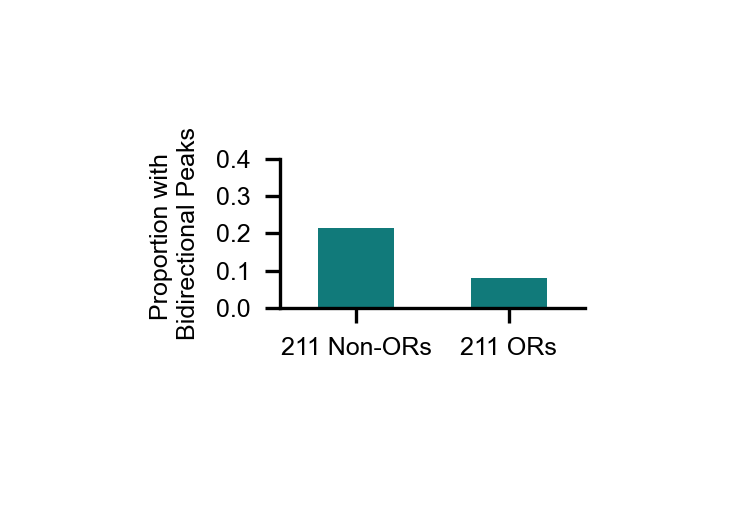

In [28]:
# Plot csRNA_opp and csRNA_same (counts) for adjacent_gene_db_subset split by both_ORs

num_non_or = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == False].shape[0]
num_or = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == True].shape[0]
print(f"Number of non-ORs: {num_non_or}")
print(f"Number of ORs: {num_or}")
mean_non_or = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == False][['twin_peaks']].mean()
mean_or = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == True][['twin_peaks']].mean()
print(f"Mean twin peaks for non-ORs: {mean_non_or['twin_peaks']}")
print(f"Mean twin peaks for ORs: {mean_or['twin_peaks']}")

f, ax = plt.subplots(1, 1, figsize=(1.75, 1), dpi=300)
sns.barplot(data=adjacent_gene_db_subset, x='both_ORs', y='twin_peaks', ax=ax, errorbar=None, palette=["darkcyan"], width=0.5)
ax.set_xticks([0, 1])
ax.set_xticklabels([f'{num_non_or} Non-ORs', f'{num_or} ORs'], fontsize=6)
ax.set_ylabel('Proportion with \nBidirectional Peaks', fontsize=6)
ax.set_xlabel('', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])

plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-twin-peaks-non-ORs.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

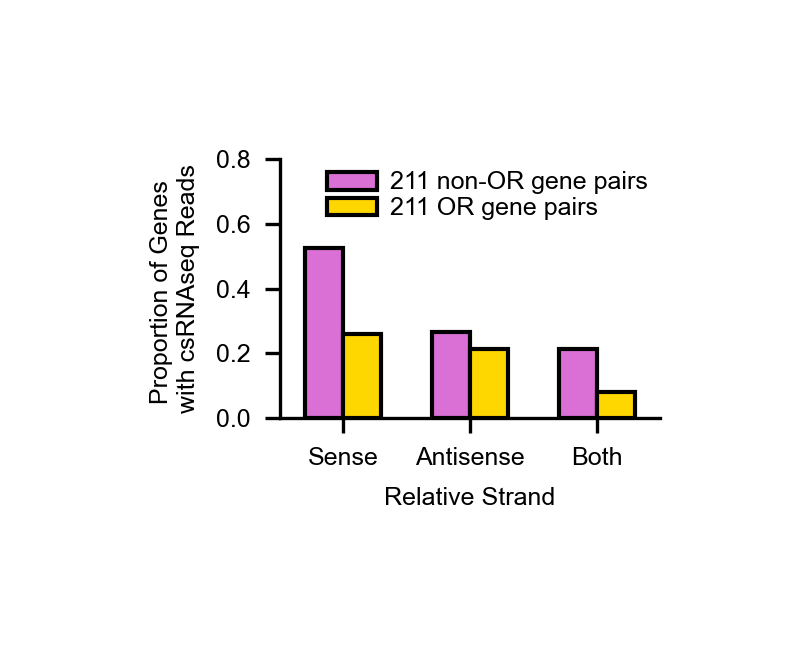

In [29]:

colors = ["orchid", "gold"]
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=300)
sns.barplot(data=adjacent_gene_db_subset, x=0, y='csRNA_same', hue='both_ORs', ax=ax, errorbar=None, palette=colors, width=0.6, legend=False, alpha=1, saturation=1, lw=1, edgecolor='black')
sns.barplot(data=adjacent_gene_db_subset, x=1, y='csRNA_opp', hue='both_ORs', ax=ax, errorbar=None, palette=colors, width=0.6, legend=False, alpha=1, saturation=1, lw=1, edgecolor='black')
sns.barplot(data=adjacent_gene_db_subset, x=2, y='twin_peaks', hue='both_ORs', ax=ax, errorbar=None, palette=colors, width=0.6, legend=False, alpha=1, saturation=1, lw=1, edgecolor='black')


ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Sense', 'Antisense', 'Both'], fontsize=6)
ax.set_ylabel('Proportion of Genes \nwith csRNAseq Reads', fontsize=6)
ax.set_xlabel('Relative Strand', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

# Custom legend 
num_non_or = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == False].shape[0]
num_or = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == True].shape[0]
legend_labels = [f'{num_non_or} non-OR gene pairs', f'{num_or} OR gene pairs']
legend_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[0], label=legend_labels[0], alpha=1, lw=1, edgecolor='black'),
                  plt.Rectangle((0, 0), 1, 1, facecolor=colors[1], label=legend_labels[1], alpha=1, lw=1, edgecolor='black')]
ax.legend(handles=legend_handles, loc='upper right', fontsize=6, frameon=False, labelspacing=0.1, handletextpad=0.5, borderpad=0)
plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-non-ORs-peaks-v2.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Assess Frequency Upstream Singletons

In [30]:
# Drop any rows with NaN in cds_start
or_db = or_db[or_db['cds_start'].notna()].reset_index(drop=True)

In [31]:
upstream_bp = 1_000 # 1kbp upstream
or_db['downstream_promoter_start'] = or_db.apply(lambda row: row['cds_start'] - upstream_bp if row['strand'] == '+' else row['cds_start'], axis=1)
or_db['downstream_promoter_end'] = or_db.apply(lambda row: row['cds_start'] if row['strand'] == '+' else row['cds_start'] + upstream_bp, axis=1)
or_db['downstream_promoter_location'] = or_db['chr'] + ':' + or_db['downstream_promoter_start'].astype(int).astype(str) + '-' + or_db['downstream_promoter_end'].astype(int).astype(str)

In [32]:
# Look for csRNA in these regions (between end_1 and start_2) 
or_db['csRNA_opp'] = False 
or_db['csRNA_same'] = False

for i, row in tqdm(or_db.iterrows(), total=or_db.shape[0], desc="Processing or_db"):
    # Look for csRNAseq data in the region between end_1 and start_2
    csRNAseq_region = csWA[(csWA['chrom'] == row['chr']) & 
                          (csWA['start'] >= row['downstream_promoter_start']) &
                          (csWA['end'] <= row['downstream_promoter_end'])].copy() 
    # If no csRNAseq data found, continue
    if csRNAseq_region.empty:
        continue 

    # Otherwise, see if there are any csRNAseq entries with opposite and same strand relative to strand_1
    csRNAseq_region['rel_strand'] = csRNAseq_region['strand'].apply(lambda x: 'same' if x == row['strand'] else 'opposite')
    or_db.at[i, 'csRNA_opp'] = csRNAseq_region[csRNAseq_region['rel_strand'] == 'opposite'].shape[0] > 0
    or_db.at[i, 'csRNA_same'] = csRNAseq_region[csRNAseq_region['rel_strand'] == 'same'].shape[0] > 0 

Processing or_db: 100%|██████████| 498/498 [00:12<00:00, 40.90it/s]


In [33]:
or_db['twin_peaks'] = or_db['csRNA_opp'] & or_db['csRNA_same']
or_db

,chromosome,gene_name,tandem_array,rank,orientation,n_transcripts,start,end,cds_start,strand,chr,nine_exon,ta_size,ta_index,downstream_promoter_start,downstream_promoter_end,downstream_promoter_location,csRNA_opp,csRNA_same,twin_peaks
0,1,Or5-R2,70,1,3',1.0,6504395,6510987,6510023.0,-,Chr1,False,2,1,6510023.0,6511023.0,Chr1:6510023-6511023,False,False,False
1,1,Or5-Q1,70,2,5',1.0,6511625,6514800,6514732.0,-,Chr1,False,2,2,6514732.0,6515732.0,Chr1:6514732-6515732,False,False,False
2,1,Or5-Orco,72,3,NaN,1.0,10910490,10919026,10911295.0,+,Chr1,False,2,1,10910295.0,10911295.0,Chr1:10910295-10911295,False,True,False
3,1,Or5-Q2,72,4,NaN,2.0,10934666,10938750,10934709.0,+,Chr1,False,2,2,10933709.0,10934709.0,Chr1:10933709-10934709,False,True,False
4,1,Or5-9E1,73,5,NaN,7.0,10980671,10984094,10981538.0,+,Chr1,True,1,1,10980538.0,10981538.0,Chr1:10980538-10981538,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,12,Or5-L35,3,498,3',1.0,8808087,8810716,8808087.0,+,Chr12,False,32,32,8807087.0,8808087.0,Chr12:8807087-8808087,True,True,True
494,12,Or5-9E350,5,499,NaN,2.0,12304526,12308947,12305782.0,+,Chr12,True,1,1,12304782.0,12305782.0,Chr12:12304782-12305782,False,True,False
495,12,Or5-9E351,6,500,NaN,3.0,13227042,13237610,13237580.0,-,Chr12,True,1,1,13237580.0,13238580.0,Chr12:13237580-13238580,False,False,False
496,12,Or5-9Efrag3,7,501,NaN,1.0,13617769,13619604,13619576.0,-,Chr12,True,1,1,13619576.0,13620576.0,Chr12:13619576-13620576,False,False,False


In [34]:
or_db[or_db['gene_name'] == "Or5-L35"]

,chromosome,gene_name,tandem_array,rank,orientation,n_transcripts,start,end,cds_start,strand,chr,nine_exon,ta_size,ta_index,downstream_promoter_start,downstream_promoter_end,downstream_promoter_location,csRNA_opp,csRNA_same,twin_peaks
493,12,Or5-L35,3,498,3',1.0,8808087,8810716,8808087.0,+,Chr12,False,32,32,8807087.0,8808087.0,Chr12:8807087-8808087,True,True,True


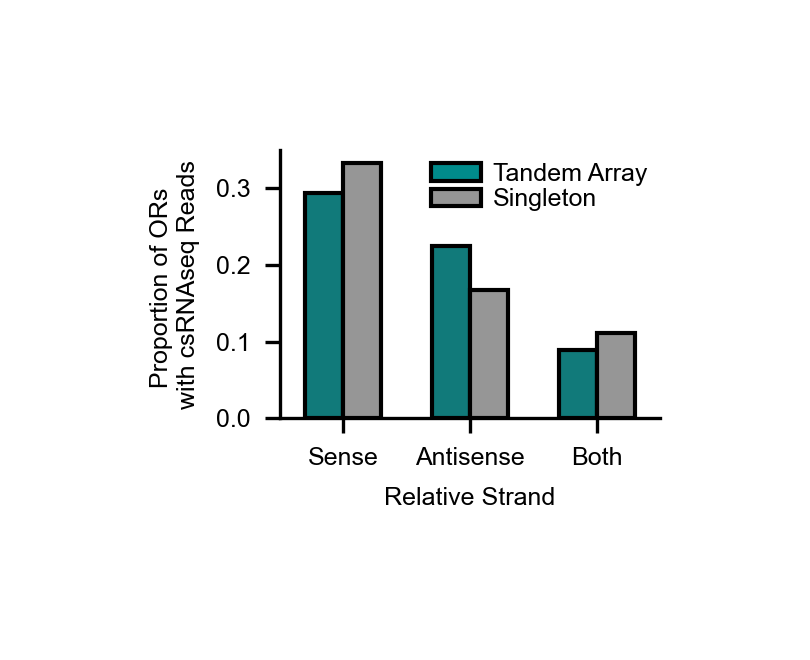

In [35]:
# Plot the number of ORs with csRNA_opp, csRNA_same, and twin_peaks 
or_db['singleton'] = or_db['ta_size'] == 1
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=300)
# Color by singleton status
sns.barplot(data=or_db, x=0, y='csRNA_same', hue='singleton', ax=ax, errorbar=None, palette=["darkcyan", "#969696"], 
            legend=False, alpha=1, estimator="mean", lw=1, edgecolor='black', width=0.6)
sns.barplot(data=or_db, x=1, y='csRNA_opp', hue='singleton', ax=ax, errorbar=None, palette=["darkcyan", "#969696"], 
            legend=False, alpha=1, estimator="mean", lw=1, edgecolor='black', width=0.6)
sns.barplot(data=or_db, x=2, y='twin_peaks', hue='singleton', ax=ax, errorbar=None, palette=["darkcyan", "#969696"], 
            legend=False, alpha=1, estimator="mean", lw=1, edgecolor='black', width=0.6)

# Make artificial legend using rectangle
legend_handles = [plt.Rectangle((0, 0), 1, 1, facecolor="darkcyan", label='Tandem Array', alpha=1, lw=1, edgecolor='black'),
                 plt.Rectangle((0, 0), 1, 1, facecolor="#969696", label='Singleton', alpha=1, lw=1, edgecolor='black')]
# Add legend to the plot
ax.legend(handles=legend_handles, loc='upper right', fontsize=6, frameon=False, labelspacing=0.1, handletextpad=0.5, borderpad=0)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Sense', 'Antisense', 'Both'], fontsize=6)
ax.set_ylabel('Proportion of ORs \nwith csRNAseq Reads', fontsize=6)
ax.set_xlabel('Relative Strand', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.1, 0.2, 0.3])
plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-prop-ORs-with-peaks-singletons.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Histogram of read length

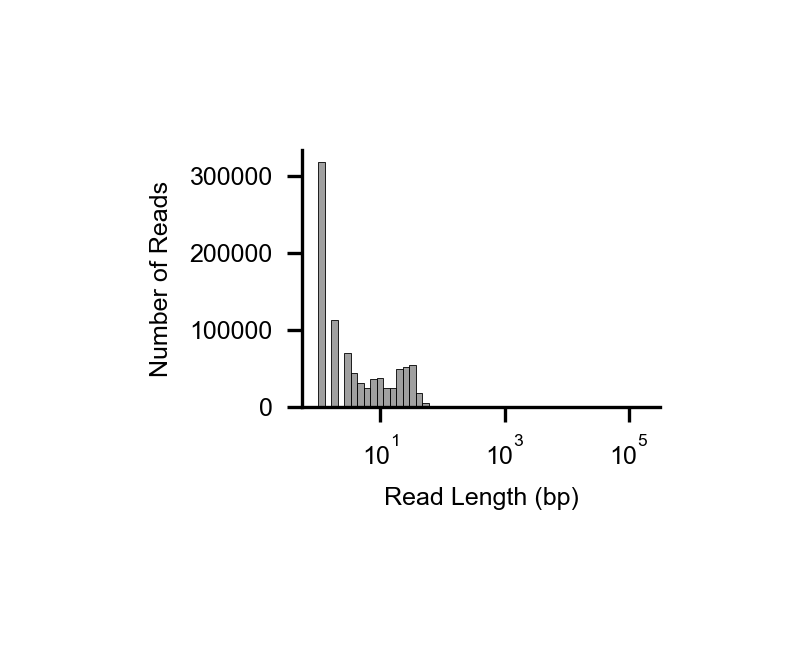

In [36]:
# Histogram of csWA read lengths 
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=300) 
sns.histplot(csWA['length'], bins=50, ax=ax, color='grey', kde=False, log_scale=True)
ax.set_xlabel('Read Length (bp)', fontsize=6)
ax.set_ylabel('Number of Reads', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-read-length-histogram.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

### Specify windows upstream of ORs to search for csRNA-seq reads

Take a 1kbp window upstream of the CDS start site

In [37]:
# Specify regions of interest (1kbp upstream of each OR's CDS start)
dist_upstream = 1000 

OR_rois = [] 

for i, row in or_db.iterrows():
    if pd.isna(row['chr']) or pd.isna(row['cds_start']):
        continue
    chrom = row['chr']
    chrom_num = int(chrom.replace('Chr', ''))  # Convert 'Chr1' to 1, 'Chr2' to 2, etc.
    strand = row['strand']
    start = row['cds_start'] - dist_upstream if strand == '+' else row['cds_start']
    end = row['cds_start'] if strand == '+' else row['cds_start'] + dist_upstream
    roi = {'chrom': chrom, 'chrom_num': chrom_num, 'start': start, 'end': end, 'strand': strand, 'gene_name': row['gene_name']}
    OR_rois.append(roi)

OR_rois = pd.DataFrame(OR_rois)
# Convert start and end to ints
OR_rois['start'] = OR_rois['start'].astype(int)
OR_rois['end'] = OR_rois['end'].astype(int)
OR_rois

,chrom,chrom_num,start,end,strand,gene_name
0,Chr1,1,6510023,6511023,-,Or5-R2
1,Chr1,1,6514732,6515732,-,Or5-Q1
2,Chr1,1,10910295,10911295,+,Or5-Orco
3,Chr1,1,10933709,10934709,+,Or5-Q2
4,Chr1,1,10980538,10981538,+,Or5-9E1
...,...,...,...,...,...,...
493,Chr12,12,8807087,8808087,+,Or5-L35
494,Chr12,12,12304782,12305782,+,Or5-9E350
495,Chr12,12,13237580,13238580,-,Or5-9E351
496,Chr12,12,13619576,13620576,-,Or5-9Efrag3


In [38]:
# Convert OR_rois to a numpy array 
OR_rois_array = OR_rois[['chrom', 'start', 'end']].to_numpy()

# Use the first column to filter 
OR_rois_array_dict = {}
for chrom, start, end in OR_rois_array:
    if chrom not in OR_rois_array_dict:
        OR_rois_array_dict[chrom] = []
    OR_rois_array_dict[chrom].append((start, end))

In [39]:
OR_rois_array_dict.keys()

dict_keys(['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5', 'Chr6', 'Chr7', 'Chr8', 'Chr9', 'Chr10', 'Chr11', 'Chr12', 'Chr14'])

### Take intersection to remove non-OR-related csRNA-seq Data

In [40]:
# Drop rows where chrom is not in OR_rois_array_dict keys 
csWA = csWA[csWA['chrom'].isin(OR_rois_array_dict.keys())].reset_index(drop=True)

In [41]:
# Take intersection of csRNAseq data with OR regions of interest
from tqdm import tqdm

# Initialize a list to store overlapping regions
overlapping = np.zeros(csWA.shape[0], dtype=bool)

for i, row in tqdm(csWA.iterrows(), total=csWA.shape[0], desc="Processing csRNAseq data"):
    OR_rois_chrom = OR_rois_array_dict[row['chrom']]
    for start, end in OR_rois_chrom:
        if start <= row['start'] and row['end'] <= end:
            # Overlapping region found
            overlapping[i] = True
            break


Processing csRNAseq data: 100%|██████████| 893560/893560 [00:44<00:00, 19879.78it/s]


In [42]:
# Look for overlapping regions
csWA['overlapping'] = overlapping
print(f"Number of overlapping regions: {np.sum(overlapping)} out of {csWA.shape[0]} total regions.")

# Filter csWA to keep only overlapping regions
csWA = csWA[csWA['overlapping']].reset_index(drop=True)

# Drop the 'overlapping' column
csWA = csWA.drop(columns=['overlapping'])

Number of overlapping regions: 869 out of 893560 total regions.


In [43]:
save_1 = csWA.copy() 

In [44]:
csWA = save_1.copy()

In [45]:
# Save gene name and strand information from OR_rois to csWA
for i, row in tqdm(csWA.iterrows(), total=csWA.shape[0], desc="Processing csRNAseq data"):
    # Find row in OR_rois 
    for j, or_row in OR_rois.iterrows():
        if row['chrom'] == or_row['chrom'] and row['start'] >= or_row['start'] and row['end'] <= or_row['end']:
            # Found a matching OR region
            csWA.at[i, 'gene_name'] = or_row['gene_name']
            csWA.at[i, 'gene_strand'] = or_row['strand']
            break

Processing csRNAseq data: 100%|██████████| 869/869 [00:02<00:00, 319.94it/s]


In [46]:
# Look for Nan Rows 
csWA[csWA.isna().any(axis=1)]

,chrom,start,end,value,strand,length,location,gene_name,gene_strand


### Merge Overlapping Reads

In [47]:
# find where gene_name is Or5-E11
csWA[csWA['gene_name'] == 'Or5-E11']

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
146,Chr9,14870015,14870058,1.23,-,43,Chr9:14870015-14870058,Or5-E11,-
147,Chr9,14870058,14870063,2.48,-,5,Chr9:14870058-14870063,Or5-E11,-
148,Chr9,14870063,14870066,8.68,-,3,Chr9:14870063-14870066,Or5-E11,-
149,Chr9,14870066,14870080,9.92,-,14,Chr9:14870066-14870080,Or5-E11,-
150,Chr9,14870080,14870103,11.16,-,23,Chr9:14870080-14870103,Or5-E11,-
151,Chr9,14870103,14870127,1.23,-,24,Chr9:14870103-14870127,Or5-E11,-
152,Chr9,14870131,14870165,1.23,-,34,Chr9:14870131-14870165,Or5-E11,-


In [48]:
# Assuming csWA is already sorted by chrom and start
csWA = csWA.sort_values(by=['chrom', 'start']).reset_index(drop=True)

# Initialize a list to store the merged rows
merged_rows = []

# Initialize the previous row as None to start the first merge
previous_row = None

# Iterate through each row
for i in range(len(csWA)):
    row = csWA.iloc[i].copy()
    
    if previous_row is None:
        # The first region becomes the initial "merged" row
        previous_row = row.copy() 
        continue
    
    # Check if the current row overlaps with the previous row (current merged region)
    if (row['chrom'] == previous_row['chrom'] and
        row['strand'] == previous_row['strand'] and
        row['start'] <= previous_row['end']):
        
        # Merge: Extend the end of the merged region
        previous_row['end'] = max(previous_row['end'], row['end'])
        previous_row['length'] = previous_row['end'] - previous_row['start']
        previous_row['location'] = previous_row['chrom'] + ':' + str(previous_row['start']) + '-' + str(previous_row['end'])

        # Take the weighted mean of 'value'
        previous_row['value'] = (previous_row['value'] * previous_row['length'] + row['value'] * row['length']) / (previous_row['length'] + row['length'])
    else:
        # If no overlap, add the previous row to the merged rows and start a new merged region
        merged_rows.append(previous_row)
        previous_row = row.copy()  # Update the previous_row to the current row

# After the loop, append the last region (since it hasn't been added yet)
merged_rows.append(previous_row)

# Convert the list of merged rows back into a DataFrame
csWA_merged = pd.DataFrame(merged_rows).reset_index(drop=True)
csWA_merged

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
0,Chr1,10910413,10910497,17.567543,+,84,Chr1:10910413-10910497,Or5-Orco,+
1,Chr1,10934665,10934691,2.480000,+,26,Chr1:10934665-10934691,Or5-Q2,+
2,Chr1,16155170,16155252,1.645712,-,82,Chr1:16155170-16155252,Or5-D2,+
3,Chr1,16155761,16155791,2.470000,-,30,Chr1:16155761-16155791,Or5-D2,+
4,Chr1,16155928,16155955,1.240000,+,27,Chr1:16155928-16155955,Or5-D2,+
...,...,...,...,...,...,...,...,...,...
284,Chr9,14882134,14882154,3.720000,-,20,Chr9:14882134-14882154,Or5-E14,-
285,Chr9,14888724,14888766,2.480000,-,42,Chr9:14888724-14888766,Or5-E15,-
286,Chr9,14888785,14888836,56.601292,-,51,Chr9:14888785-14888836,Or5-E15,-
287,Chr9,14888845,14888887,2.428719,-,42,Chr9:14888845-14888887,Or5-E15,-


In [49]:
save_2 = csWA_merged.copy()

In [50]:
csWA = csWA_merged.copy()

In [51]:
csWA = csWA.sort_values(by=['value'], ascending=False)

In [52]:
# Get strand relative to gene 
csWA['rel_strand'] = np.where(csWA['strand'] == csWA['gene_strand'], 'sense', 'antisense')

In [53]:
csWA['tss'] = np.where(csWA['strand'] == '+', csWA['start'], csWA['end'])
csWA

,chrom,start,end,value,strand,length,location,gene_name,gene_strand,rel_strand,tss
184,Chr4,10527180,10527236,562.590346,+,56,Chr4:10527180-10527236,Or5-9E108,-,antisense,10527180
20,Chr10,1963639,1963688,473.125627,+,49,Chr10:1963639-1963688,Or5-9E241,-,antisense,1963639
109,Chr12,8761335,8761369,311.071569,+,34,Chr12:8761335-8761369,Or5-L22,+,sense,8761335
199,Chr4,10603206,10603259,101.522030,+,53,Chr4:10603206-10603259,Or5-9E118,-,antisense,10603206
264,Chr7,5138097,5138138,95.484292,-,41,Chr7:5138097-5138138,Or5-U64,+,antisense,5138138
...,...,...,...,...,...,...,...,...,...,...,...
92,Chr11,9784268,9784302,1.050000,-,34,Chr11:9784268-9784302,Or5-E21,-,sense,9784302
96,Chr11,13626596,13626622,1.040000,-,26,Chr11:13626596-13626622,Or5-9E348,-,sense,13626622
94,Chr11,13613197,13613227,1.040000,-,30,Chr11:13613197-13613227,Or5-9E345,-,sense,13613227
93,Chr11,13606753,13606775,1.040000,-,22,Chr11:13606753-13606775,Or5-9E353,-,sense,13606775


In [54]:
csWA['gene_first_cds'] = csWA['gene_name'].apply(lambda x: int(or_db.loc[or_db['gene_name'] == x, 'cds_start'].values[0]))
csWA

,chrom,start,end,value,strand,length,location,gene_name,gene_strand,rel_strand,tss,gene_first_cds
184,Chr4,10527180,10527236,562.590346,+,56,Chr4:10527180-10527236,Or5-9E108,-,antisense,10527180,10526774
20,Chr10,1963639,1963688,473.125627,+,49,Chr10:1963639-1963688,Or5-9E241,-,antisense,1963639,1963296
109,Chr12,8761335,8761369,311.071569,+,34,Chr12:8761335-8761369,Or5-L22,+,sense,8761335,8761369
199,Chr4,10603206,10603259,101.522030,+,53,Chr4:10603206-10603259,Or5-9E118,-,antisense,10603206,10602836
264,Chr7,5138097,5138138,95.484292,-,41,Chr7:5138097-5138138,Or5-U64,+,antisense,5138138,5138976
...,...,...,...,...,...,...,...,...,...,...,...,...
92,Chr11,9784268,9784302,1.050000,-,34,Chr11:9784268-9784302,Or5-E21,-,sense,9784302,9783793
96,Chr11,13626596,13626622,1.040000,-,26,Chr11:13626596-13626622,Or5-9E348,-,sense,13626622,13626581
94,Chr11,13613197,13613227,1.040000,-,30,Chr11:13613197-13613227,Or5-9E345,-,sense,13613227,13613184
93,Chr11,13606753,13606775,1.040000,-,22,Chr11:13606753-13606775,Or5-9E353,-,sense,13606775,13606729


In [55]:
csWA['tss_2_gene'] = abs(csWA['tss'] - csWA['gene_first_cds'])

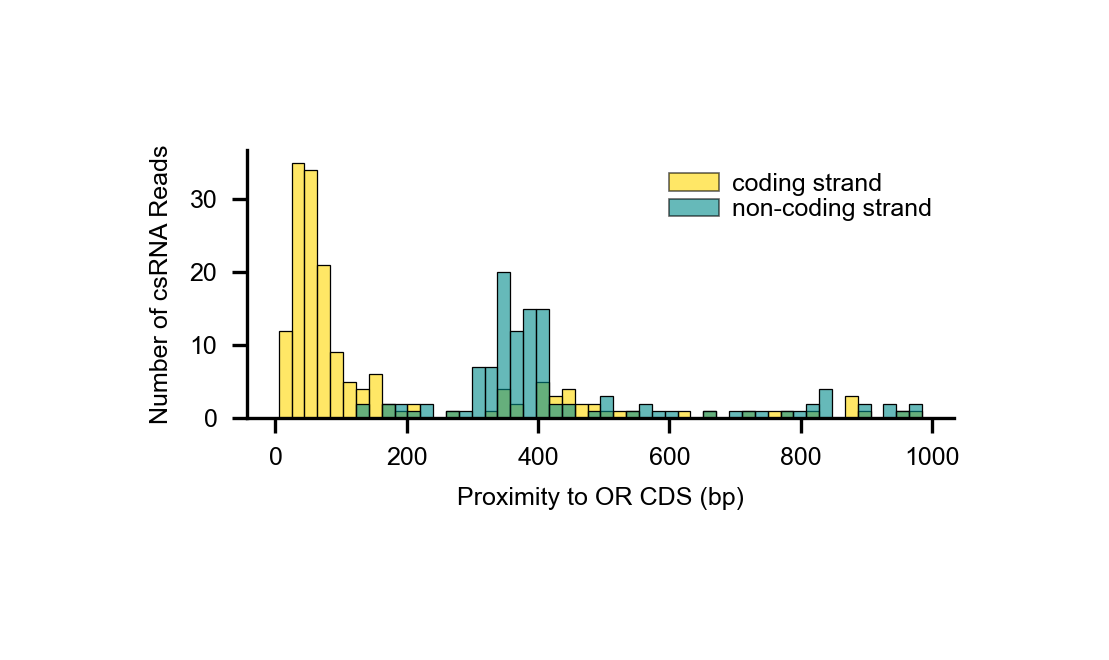

In [62]:
# Histogram of tss_2_gene split by rel_strand 
f, ax = plt.subplots(1, 1, figsize=(3, 1.5), dpi=300)
sns.histplot(data=csWA, x='tss_2_gene', hue='rel_strand', bins=50, ax=ax, kde=False, palette=["darkcyan", "gold"], stat='count', alpha=0.6, legend=False)
ax.set_xlabel('Proximity to OR CDS (bp)', fontsize=6)
ax.set_ylabel('Number of csRNA Reads', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make artificial legend 
handles = [plt.Rectangle((0, 0), 1, 1, facecolor='gold', lw=0.4, label='coding strand', alpha=0.6, edgecolor='black'),
           plt.Rectangle((0, 0), 1, 1, facecolor='darkcyan', lw=0.4, label='non-coding strand', alpha=0.6, edgecolor='black')]
ax.legend(handles=handles, loc='upper right', fontsize=6, frameon=False, labelspacing=0.1, handletextpad=0.5)

# Save the figure
plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-tss-2-gene-histogram.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()